In [128]:
# Importacion de librerias
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,median_absolute_error,mean_squared_error,max_error,explained_variance_score,mean_absolute_error,mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

# Librerias de visualizacion de datos.
import seaborn as sns
import matplotlib.pyplot as plt

# Tratamiento de datos
import pandas as pd
import numpy as np

# Ignorar errores
import warnings
warnings.filterwarnings('ignore')

# Multiprocesamiento
import multiprocessing

# Aleatoriedad
import random


In [129]:
df_train = pd.read_csv('train.csv')
df_train.dropna(subset=['Burn Rate'],inplace=True)
df_train.shape

(21626, 9)

In [130]:
df_train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [131]:
# Separo entre features y target.
X = df_train.drop(['Employee ID','Date of Joining','Burn Rate'],axis=1)
y = df_train['Burn Rate']

In [132]:
# Separo el dataset en Train y Test.
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17300, 6) (17300,) (4326, 6) (4326,)


In [133]:
# Obtener columnas categoricas y numericas
cat_col = X_train.select_dtypes(include='O').columns.tolist()
print('Categoricas --> ',cat_col)
num_col = X_train.select_dtypes(exclude='O').columns.tolist()
print('Numericas --> ',num_col)

Categoricas -->  ['Gender', 'Company Type', 'WFH Setup Available']
Numericas -->  ['Designation', 'Resource Allocation', 'Mental Fatigue Score']


In [134]:
# Generar a pipeline para numericas 
numeric_transformer = Pipeline(
    steps=[
        ('imputation',KNNImputer( 
            missing_values=np.nan, 
            n_neighbors=5, 
            weights='uniform', 
            metric="nan_euclidean",
            copy=False,
            add_indicator=False,
            )
        ),
        ('StandardScaler', StandardScaler())        
    ]
)

# Generar un pipeline para categoricas
categorical_transformer = Pipeline(
    steps=[
        ("ohe",OneHotEncoder(drop='first',handle_unknown='ignore')),
    ]
)

# Funcion que realiza el trabajo para cada pipeline y luego unirlo
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, make_column_selector(dtype_include = object),),
        ('num', numeric_transformer, make_column_selector(dtype_include = np.number)),
    ], remainder='drop'
)


# Obtencion de los procesos en el X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002C519B67220>),
                                ('num',
                                 Pipeline(steps=[('imputation',
                                                  KNNImputer(copy=False)),
                                                 ('StandardScaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002C519B67EB0>)])

In [135]:
# Aplico la transformacion al X_train con los pipelines procesados.
X_array_enc = preprocessor.transform(X_train)

In [136]:
# Transformacion de X_train 
X_array_enc = preprocessor.transform(X_train)

X_train_enc = pd.DataFrame(X_array_enc[:,:], columns = preprocessor.get_feature_names_out(), index = X_train.index)
X_train_enc

,cat__Gender_Male,cat__Company Type_Service,cat__WFH Setup Available_Yes,num__Designation,num__Resource Allocation,num__Mental Fatigue Score
15252,0.0,1.0,1.0,-1.038738,-0.727202,-0.923910
7102,1.0,1.0,0.0,1.607826,0.748101,0.816157
19462,0.0,1.0,0.0,-0.156550,-1.218970,-0.765722
20566,0.0,0.0,0.0,-1.920926,-1.710738,-1.683212
4378,0.0,1.0,1.0,-0.156550,-0.235435,0.816157
...,...,...,...,...,...,...
6508,1.0,0.0,0.0,-1.038738,-1.218970,-1.978496
1416,1.0,1.0,0.0,-0.156550,0.256333,1.027074
13074,1.0,0.0,0.0,-1.038738,-0.235435,-0.396617
2033,0.0,1.0,1.0,-1.038738,-0.727202,-1.134827


In [137]:
# Transformacion de X_test
X_test_array_enc = preprocessor.transform(X_test)

X_test_enc = pd.DataFrame(X_test_array_enc[:,:], columns = preprocessor.get_feature_names_out(), index = X_test.index)
X_test_enc

,cat__Gender_Male,cat__Company Type_Service,cat__WFH Setup Available_Yes,num__Designation,num__Resource Allocation,num__Mental Fatigue Score
19135,0.0,1.0,1.0,0.725638,1.239869,1.185262
17305,0.0,0.0,1.0,-1.038738,-0.727202,0.130676
6895,1.0,0.0,1.0,-0.156550,-1.218970,-0.976639
3543,0.0,1.0,1.0,-0.156550,-0.235435,0.236135
10945,0.0,0.0,0.0,0.725638,0.256333,0.077947
...,...,...,...,...,...,...
14074,0.0,1.0,0.0,-1.038738,-1.218970,-1.187556
21691,1.0,1.0,1.0,0.725638,0.748101,0.236135
11698,0.0,1.0,0.0,-1.038738,-1.218970,-1.925766
794,1.0,1.0,1.0,-0.156550,-0.235435,-0.396617


In [138]:
# Usamos mismas semillas

randomState = 45
Num_estimators = 100
jobs = None
maxDepth = 10
maxFeature = None

name_model=[]
models = []
r2 = []
m = []
mae = []
mse = []
rss = []
rmse = []
mape = []
train_value = []
test_value =[]
predict_value = []
residuo_value = []
meanAbsoluteError = []

# Instanciamos los algoritmos a utilizar
lr = LinearRegression(
    fit_intercept=True,
    normalize="deprecated",
    copy_X=True,
    n_jobs=jobs,
    positive=False,
)

rf = RandomForestRegressor(
    n_estimators=Num_estimators,
    criterion="squared_error",
    max_depth=maxDepth,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=jobs,
    random_state=randomState,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)

knr = KNeighborsRegressor(
    n_neighbors=5,
    weights="uniform",
    algorithm="auto",
    leaf_size=30,
    p=2,
    metric="minkowski",
    metric_params=None,
    n_jobs=jobs,
)

gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.1,
    n_estimators=Num_estimators,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=maxDepth,
    min_impurity_decrease=0.0,
    init=None,
    random_state=randomState,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=1e-4,
    ccp_alpha=0.0,    
)

dtr= DecisionTreeRegressor(
    criterion="squared_error",
    splitter="best",
    max_depth=maxDepth,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=randomState,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,    
)


xgb = XGBRegressor(
    objective= 'reg:squarederror',
    base_score= None,
    booster= None,
    callbacks= None,
    colsample_bylevel= None,
    colsample_bynode= None,
    colsample_bytree= None,
    early_stopping_rounds= None,
    enable_categorical= False,
    eval_metric= None,
    gamma= None,
    gpu_id= None,
    grow_policy= None,
    importance_type= None,
    interaction_constraints= None,
    learning_rate= None,
    max_bin= None,
    max_cat_to_onehot= None,
    max_delta_step= None,
    max_depth= None,
    max_leaves= None,
    min_child_weight= None,
    monotone_constraints= None,
    n_estimators= 100,
    n_jobs= jobs,
    num_parallel_tree= None,
    predictor= None,
    random_state= randomState,
    reg_alpha= None,
    reg_lambda= None,
    sampling_method= None,
    scale_pos_weight= None,
    subsample= None,
    tree_method= None,
    validate_parameters= None,
    verbosity= None    
)

lgb = LGBMRegressor(
    boosting_type= 'gbdt',
    class_weight= None,
    colsample_bytree= 1.0,
    importance_type= 'split',
    learning_rate= 0.1,
    max_depth= -1,
    min_child_samples= 20,
    min_child_weight= 0.001,
    min_split_gain= 0.0,
    n_estimators= 100,
    n_jobs= jobs,
    num_leaves= 31,
    objective= None,
    random_state= randomState,
    reg_alpha= 0.0,
    reg_lambda= 0.0,
    silent= 'warn',
    subsample=1.0,
    subsample_for_bin= 200000,
    subsample_freq= 0    
)


In [139]:
# Carga de modelos.

models.append(lr)
models.append(rf)
models.append(knr)
models.append(gbr)
models.append(dtr)
models.append(xgb)
models.append(lgb)

In [140]:
# Entrenamiento de modelos y generacion de metricas de regresion.

for model in models:
    
    # Nombre Modelo
    name_model.append(model.__class__.__name__)

    # Entreno Modelo
    model.fit(X_train_enc,y_train)
    
    # Prediccion
    y_predict = model.predict(X_test_enc)

    # Metricas

    # Error absoluto máximo
    m.append(max_error(y_test,y_predict))
    
    # R2
    r2.append(model.score(X_train_enc,y_train))

    # mean_absolute_error
    meanAbsoluteError.append(mean_absolute_error(y_test,y_predict))

    # MAE (Median Absolute Error)
    mae.append(median_absolute_error(y_test,y_predict))

    # Mean Squared Error
    mse.append(mean_squared_error(y_test,y_predict))

    # Suma de los cuadrados de los residuos
    rss.append(mean_squared_error(y_test,y_predict)*len(y_predict))

    # Suma de los cuadrados de los residuos
    rmse.append(mean_squared_error(y_test,y_predict,squared=False))

    # Valores de Train
    train_value.append(y_train)

    # Valores Test
    test_value.append(y_test)

    # Valores Prediccion
    predict_value.append(y_predict)

    # Diferencia
    residuo_value.append(y_test - y_predict)

    # Porcentaje de error absoluto medio
    mape.append(mean_absolute_percentage_error(y_test,y_predict))
    

In [141]:
# Listar resultados
resultados = {
    'Nombre_modelo':name_model,
    'Modelos':models,
    'M':m,
    'EAM': meanAbsoluteError,
    'R2':r2,
    'MAE':mae,
    'MSE':mse,
    'RSS':rss,
    'RMSE':rmse,
    'MAPE':mape,
    'Test': test_value,
    'Predict': predict_value,
    'Residuo': residuo_value
}

# Comparacion de algoritmos por sus metricas

***
### Metricas usadas para algoritmo de regresion.
***

##### Los modelos de regresión es casi imposible predecir el valor exacto, sino que más bien se busca estar lo más cerca posible del valor real, por lo que la mayoría de las métricas, con sutiles diferencias entre ellas, van a centrarse en medir eso: lo cerca (o lejos) que están las predicciones de los valores reales.

##### En los modelos de regresión hay que considerar los valores anómalos y si queremos penalizar errores grandes o no.

***

*Ejemplo para entender las metricas.*

##### *y_verdadero = [1,2,3,4,5]*
##### *y_predicho = [1,2,3,4,-5]*


##### R cuadrado o coeficiente de determinacion, *Evalua que tan bien se ajusta nuestro modelo a los datos. Valor segun array ejemplo = <b>*

##### M: Error absoluto máximo, *muestra el error absoluto maximo de toda las observaciones. Valor segun array ejemplo = <b> 10*

##### MAE: Error absoluto medio, *Es el promedio de la suma de los residuos absolutos entre el array del valor predicho y el valor verdadero. Castiga menos a los numeros chicos. Valor segun array ejemplo = <b>2*

##### MSE: Error cuadrático medio. *Es el promedio de la suma del cuadrado de los residuos entre el array del valor predicho y el valor verdadero, lo que hace elevarlo al cuadrado aumenta el peso de los errores grandes que los errores pequeños. Valor segun array ejemplo = <b>20*

##### RSS: Suma de los cuadrados de los residuos. *Es la suma del cuadrado de los residuos entre el array del valor predicho y el valor verdadero. Valor segun array ejemplo = <b>100*

##### RMSE: Raíz cuadrada del error cuadrático medio. *Es el MSE pero agregado la raiz para nos indique en la unidad de nuestro modelo de regresion. Valor segun array ejemplo = <b>4.47213...*



In [142]:
# Crear Dataframe con los resultados
df = pd.DataFrame(resultados)
df

,Nombre_modelo,Modelos,M,EAM,R2,MAE,MSE,RSS,RMSE,MAPE,Test,Predict,Residuo
0,LinearRegression,LinearRegression(),0.361589,0.048843,0.900759,0.041541,0.003866,16.725395,0.062179,2.954656e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.6806677263246029, 0.4249051940103664, 0.242...",19135 0.069332 17305 0.005095 6895 0...
1,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=10, max_featu...",0.301705,0.046276,0.922296,0.038597,0.003482,15.061347,0.059005,1.372997e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.7034571603150584, 0.42334761367768814, 0.23...",19135 0.046543 17305 0.006652 6895 0...
2,KNeighborsRegressor,KNeighborsRegressor(),0.338000,0.050192,0.921108,0.042000,0.004125,17.846136,0.064229,1.451229e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.696, 0.4159999999999999, 0.2279999999999999...",19135 0.054 17305 0.014 6895 0.042 3...
3,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,0.292775,0.048680,0.933512,0.040654,0.003878,16.776749,0.062275,1.323199e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.7067965499056659, 0.41975804384425724, 0.19...",19135 0.043203 17305 0.010242 6895 0...
4,DecisionTreeRegressor,"DecisionTreeRegressor(max_depth=10, random_sta...",0.314272,0.047256,0.919259,0.039310,0.003630,15.705178,0.060253,1.465299e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.7044827586206898, 0.42522727272727256, 0.24...",19135 0.045517 17305 0.004773 6895 0...
5,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.293279,0.046321,0.923317,0.038088,0.003514,15.203564,0.059283,1.398839e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.70250183, 0.42757627, 0.22533223, 0.4587785...",19135 0.047498 17305 0.002424 6895 0...
6,LGBMRegressor,"LGBMRegressor(n_jobs=None, random_state=45)",0.301777,0.046171,0.916926,0.038442,0.003464,14.983942,0.058853,1.423787e+12,19135 0.75 17305 0.43 6895 0.27 3543...,"[0.7082675327314645, 0.4277453272472771, 0.231...",19135 0.041732 17305 0.002255 6895 0...


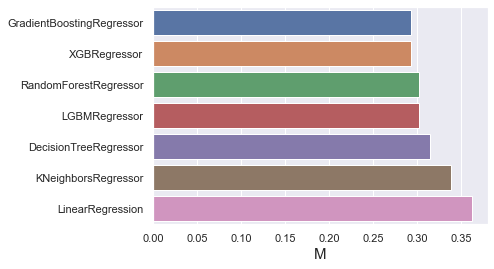

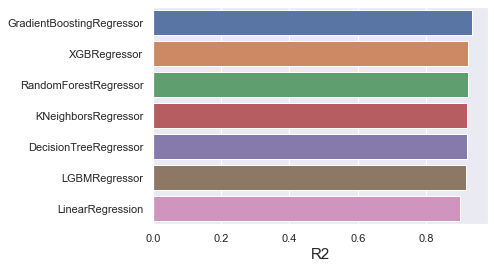

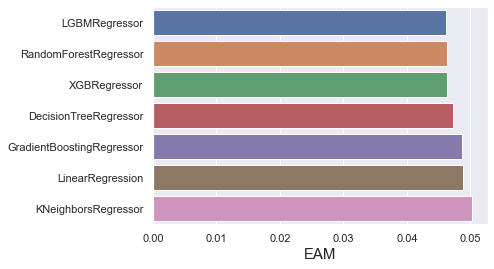

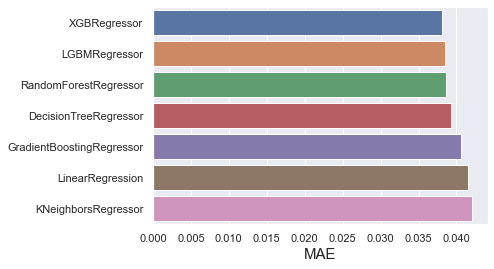

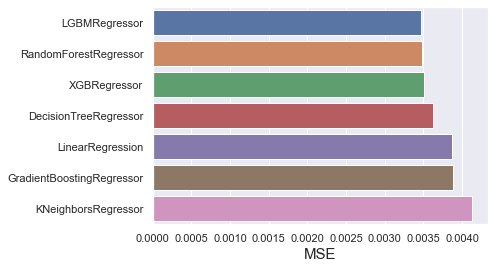

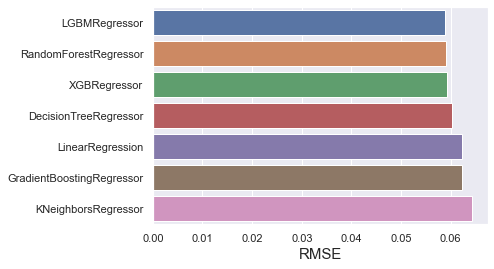

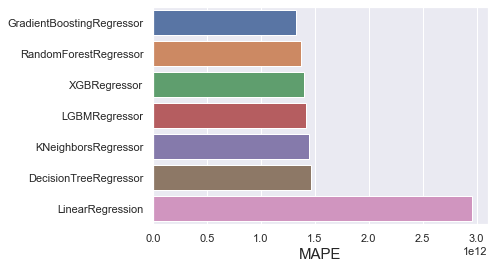

In [196]:
metrics=['M','R2','EAM','MAE','MSE','RMSE','MAPE']

for i in metrics:
    if i == 'R2':
        _df_ = df[['Nombre_modelo',f'{i}']].sort_values(by=[f'{i}'],ascending=False)
    else:
        _df_ = df[['Nombre_modelo',f'{i}']].sort_values(by=[f'{i}'],ascending=True)
    
    sns.set_theme(rc={"font.size":9,"axes.titlesize":20,"axes.labelsize":15})
    sns.barplot(
        x=f'{i}', y='Nombre_modelo',
        hue=None, data=_df_,
        order=None, hue_order=None,
        estimator=np.mean, ci=95, n_boot=1000, units=None, seed=None,
        orient=None, color=None, palette=None, saturation=.75,
        errcolor=".26", errwidth=None, capsize=None, dodge=True,
        ax=None      
    )
    
    plt.ylabel('')
    plt.show()

In [144]:
def plot_diagnostic(df_):
    for i in range(df_.count()[0]):

        nombre_modelo= df_['Nombre_modelo'][i]
        df_new = pd.DataFrame( pd.Series(df_.Test[0]) ).reset_index().rename(columns={'index':'index_value','Burn Rate':'Real'})
        Predict = pd.DataFrame( pd.Series(df_.Predict[0]) ).rename(columns={0:'Predict'})
        Residue= pd.DataFrame( pd.Series(df_.Residuo[0]) ).reset_index().rename(columns={'index':'index_value','Burn Rate':'Residuo'})

        Predict['index_value'] = df_new['index_value']

        df_new = df_new.merge(Predict,how='left')
        df_new = df_new.merge(Residue, how= 'left')

        fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))

        ax[0].scatter(
            df_new['Predict'], 
            df_new['Real'], 
            edgecolors='face', 
            alpha = 0.2
        )

        ax[0].plot(
            [df_new['Real'].min(), df_new['Real'].max()], 
            [df_new['Real'].min(), df_new['Real'].max()],
            'k--', 
            color = 'black', 
            lw=2
        )
        ax[0].set_title('Valor predicho vs valor real', fontsize = 12, fontweight = "bold")
        ax[0].set_xlabel('Real')
        ax[0].set_ylabel('Predicción')
        ax[0].tick_params(labelsize = 10)

        ax[1].scatter(
            x=list(range(len(df_new['Real']))), 
            y=df_new['Residuo'],
            edgecolors='face', 
            alpha = 0.2
        )

        ax[1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
        ax[1].set_title('Dispersión de residuos', fontsize = 12, fontweight = "bold")
        ax[1].set_xlabel('id')
        ax[1].set_ylabel('Residuo')
        ax[1].tick_params(labelsize = 7)

        sns.histplot(
            data    = df_new['Residuo'],
            stat    = "count",
            kde     = True,
            line_kws= {'linewidth': 2},
            color   = "firebrick",
            alpha   = 0.2,
            ax      = ax[2]
        )

        ax[2].set_title('Distribución de residuos', fontsize = 12,fontweight = "bold")
        ax[2].set_xlabel("Residuo")
        ax[2].tick_params(labelsize = 7)

        fig.tight_layout()
        plt.subplots_adjust(top=0.9)
        fig.suptitle(f'Diagnóstico residuos: {nombre_modelo}', fontsize = 20, fontweight = "bold");
        fig.show()

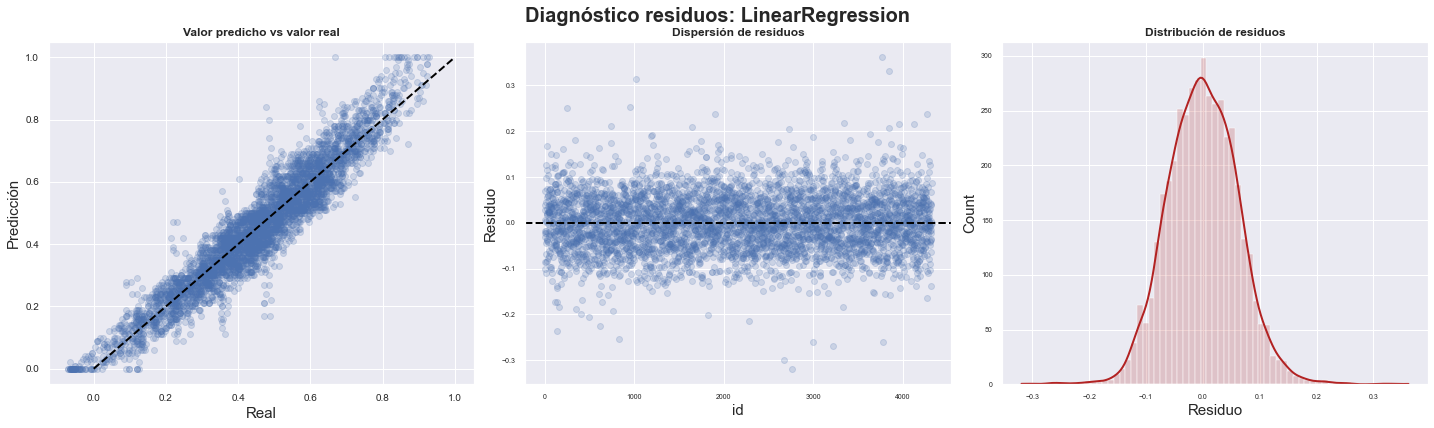

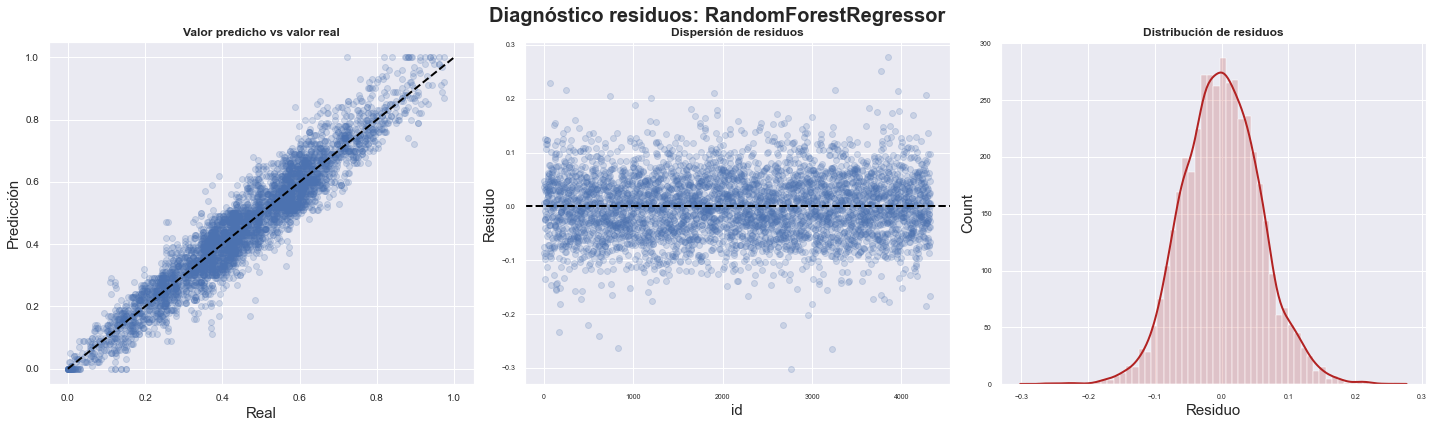

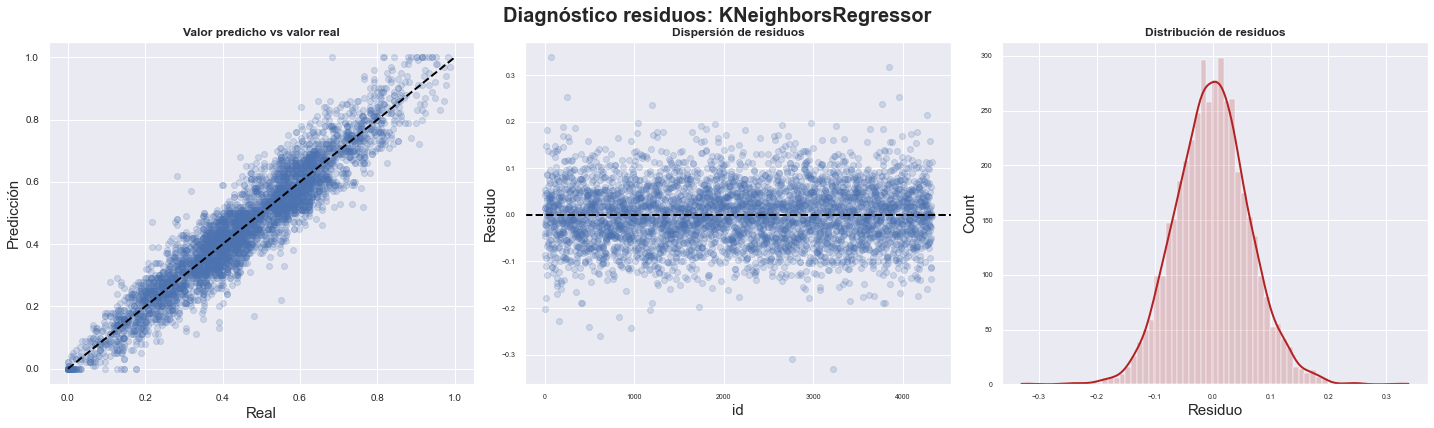

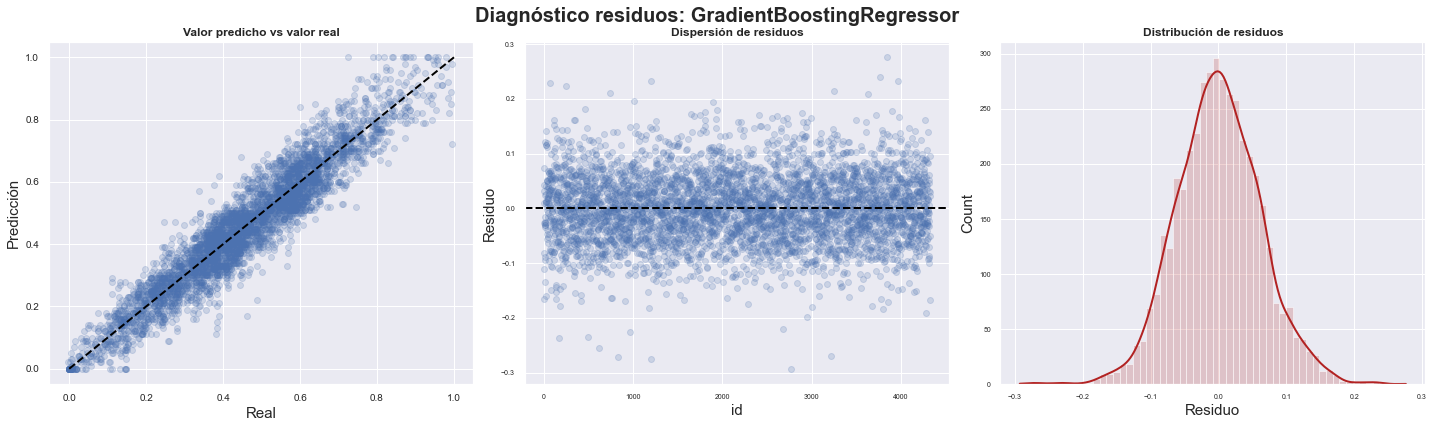

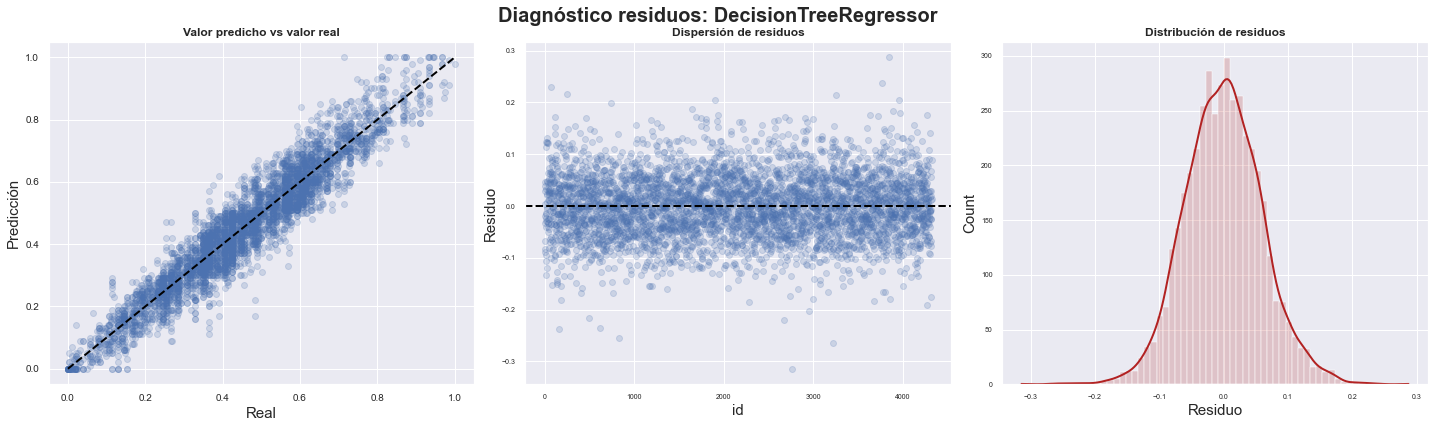

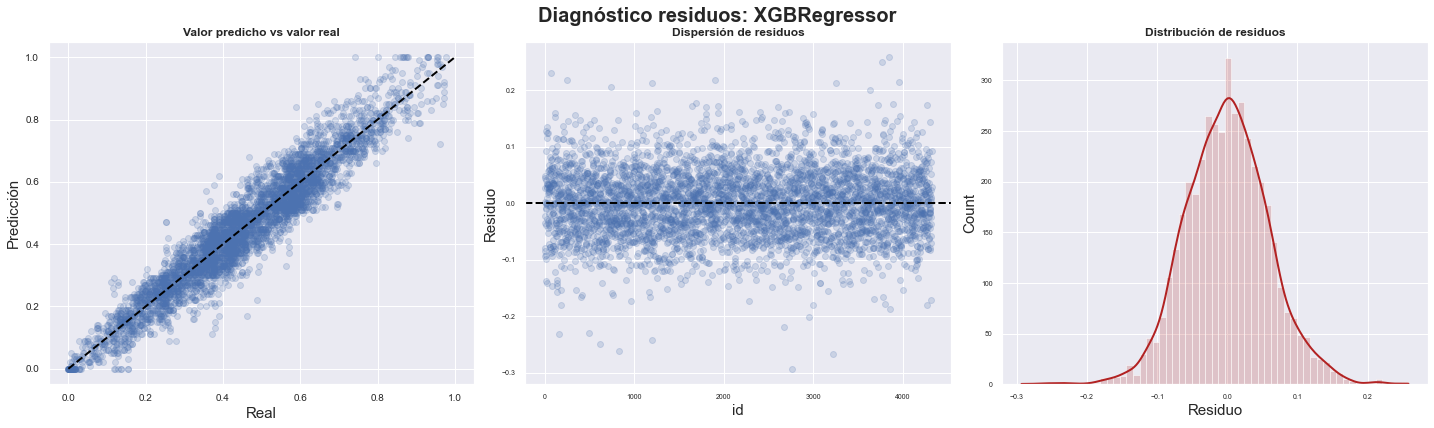

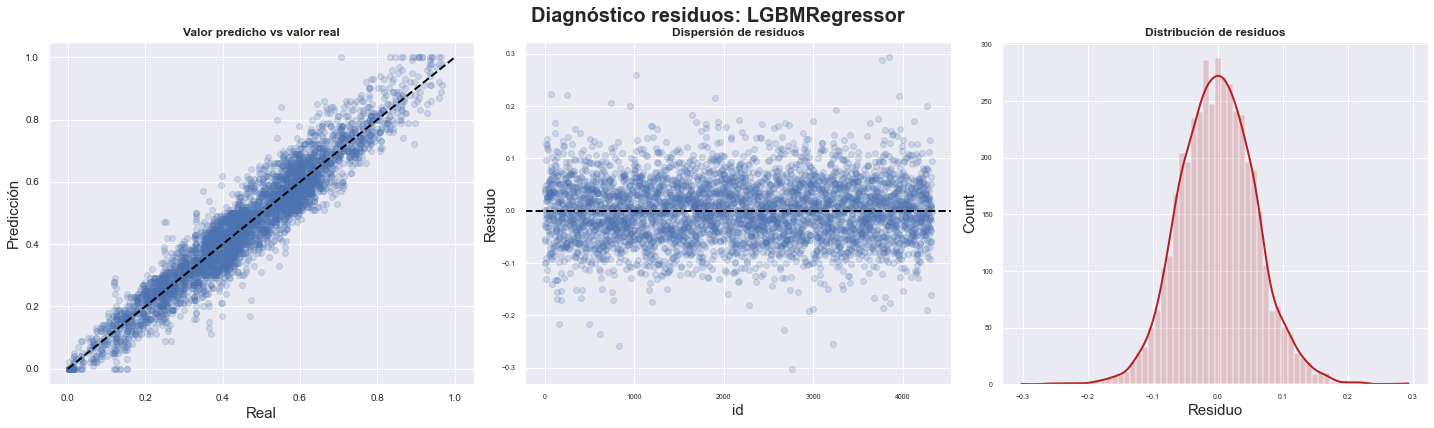

In [145]:
plot_diagnostic(df)

# Residuos:

* La comparacion de los residuos de cada modelo es muy similar.

* La dispersion de los residuos nos muestran que la mayoria de los registros se encuentran entre -0,1 y 0,1.

* Al tener un Burn Rate que va del rango entre 0 y 1, podriamos tratar los valores fuera de los rangos de residuos entre -0,1 y 0,1.

In [146]:
df_ = df[['Nombre_modelo','R2','RMSE','MAE']].sort_values(by=['RMSE'],ascending=True)

df_

,Nombre_modelo,R2,RMSE,MAE
6,LGBMRegressor,0.916926,0.058853,0.038442
1,RandomForestRegressor,0.922296,0.059005,0.038597
5,XGBRegressor,0.923317,0.059283,0.038088
4,DecisionTreeRegressor,0.919259,0.060253,0.039310
0,LinearRegression,0.900759,0.062179,0.041541
3,GradientBoostingRegressor,0.933512,0.062275,0.040654
2,KNeighborsRegressor,0.921108,0.064229,0.042000


### <b>Conclusiones:</b>

#### *Notamos que casi todas las metricas utilizadas tiene una variablidad entre ellas por cada modelo muy bajo. Para nuestro modelo usaremos la metrica de RMSE ya que pretendemos generalizar el modelo basandonos en los resultados de nuestras predicciones, esta métrica nos indicara el intervalo en el cual pueden estar nuestras predicciones*

#### *Como podemos visualizar en la comparacion de las metricas el modelo LGBMRegressor tiene el RMSE mas bajo, por lo que usaremos este algortimo para nuestro proyecto*

# Hiper parámetros aplicado el modelo seleccionado

In [147]:
# Parámetros globales
num_estimators = np.linspace(100, 700, num = 10, endpoint = True).astype(int)
max_depth = random.sample(range(1, 50), 20)
learning_rate = np.arange (0.001, 1, 0.005)

# Parámetros
params_global = {
    'n_estimators': num_estimators,
    'max_depth': max_depth, 
    'learning_rate': learning_rate
}

In [148]:
# Aplicacion de la tecnica RandomizedSearchCV
results = {}

# Modelo segun métrica tomado.
model = LGBMRegressor()

print(f'Start training {model.__class__.__name__}')

# Aplicación
modeling = RandomizedSearchCV(
    model, 
    params_global, 
    cv=5, 
    n_jobs=-1, 
    refit=True, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    n_iter=30
)

# Entrenamiento
modeling.fit(X_train_enc, y_train)

# Selección del modelo con refit 
best_model = modeling.best_estimator_

# Métrica de test
metrics_test = mean_squared_error(y_test, best_model.predict(X_test_enc),squared=False)

# Guardo resultados del mejor modelo.
results[best_model.__class__.__name__] = {
    'modelo': best_model,
    'score_train': modeling.best_score_ * -1,
    'score_test': metrics_test,
    'best_model_r2':r2_score(y_test,best_model.predict(X_test_enc)),
    'mape':mean_absolute_percentage_error(y_test,best_model.predict(X_test_enc)),
    'params': modeling.best_params_
}

Start training LGBMRegressor
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [149]:
# Genero dataset con las comparaciones que tenia anteriormente y le agrego los resultados del hipertuning.
hipertuning_model = df_[ (df_['RMSE'].min())==df_['RMSE']]

for i in results:
    for a in results[f'{i}']:
        if a == 'params':
            hipertuning_model[f'{a}'] = [results[f'{i}'][f'{a}']]
            hipertuning_model['best_model_metric_RMSE'] = results[f'{i}']['score_test']
            hipertuning_model['best_model_r2'] = results[f'{i}']['best_model_r2']

In [150]:
# Vista de resultados con hipertuning.
hipertuning_model.T.rename(columns={6:'valores'})

,valores
Nombre_modelo,LGBMRegressor
R2,0.916926
RMSE,0.058853
MAE,0.038442
params,"{'n_estimators': 100, 'max_depth': 13, 'learni..."
best_model_metric_RMSE,0.058819
best_model_r2,0.911767


In [151]:
# Parámetros del mejor modelo de LGBMRegressor
for i in hipertuning_model.params:
    print(i)

{'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.051000000000000004}


# Conclusiones:

#### Para el modelo seleccionado por la metrica RMSE, LGBMRegressor, los mejores parámetros para obtener el menor erro de la raíz cuadrada del error cuadrático medio serian:
* n_estimators : 366,
* max_depth : 9
* learning_rate : 0.016